# Zastosowanie algorytmu NSGA2 dla Problemu Plecakowego

**Dane**
1. Zbiór przedmiotów - każdy posiada wagę oraz wartość z przedziału \[0, 1).
2. Plecak posiadają znaną, skończoną pojemność k.
3. Wybierany jest podzbiór danego zbioru przedmiotów, mieszczący się w plecaku - suma wag mniejsza, bądź równa k.

**Cel**

Maksymalizacja sumarycznej wartości wybranych przedmiotów - przy jednoczesnej minimalizacji sumy wag oraz nie przekroczeniu zadanej maksymalnej pojemności plecaka.

In [1]:
from random import random, randrange
from pandas import DataFrame, read_csv

**Algorytm NSGA2**

Dane: zbiór przedmiotów, ilość generacji, rozmiar populacji, k oraz prawdopodobieństwo mutacji.

1. Generowana jest populacja początkowa o danym rozmiarze (_Chromosome.random_) w postaci chromosomów reprezentowanych przez listy bitów, których długość jest równa ilości przedmiotów.
2. Dla każdej kolejnej generacji wykonywane są w pętli kolejne punkty.
3. Wykonywana jest operacja selekcji turniejowej - powstaje lista par rodziców.
4. Wykonywana jest operacja crossoveru - generowany jest zbiór dzieci.
5. Wykonywana jest operacja mutacji dzieci - z zadanym prawdopodobieństwem. Dzieci dodawane są do bieżącej populacji.
6. Wykonywany jest algorytm "Non-dominated sorting".
7. Wykonywany jest algorytm "Crowding distance sorting".
8. Usuwane są duplikaty z populacji (celem optymalizacji).

Otrzymany wynik to posortowana lista chromosomów, zatem pierwszy z nich jest "najlepszym" osobnikiem.

### Klasy modelowe

In [2]:
class Item:
    def __init__(self, weight, value):
        self.weight = weight
        self.value = value
    
    def __str__(self):
        return f"Weight: {self.weight} | Value: {self.value}"

In [3]:
class Chromosome:
    def __init__(self, size, selected=[]):
        self.size = size
        self.selected = selected

    @staticmethod
    def random(size):
        selected = []
        for i in range(size):
            selected.append(random() >= 0.5)
        return Chromosome(size, selected)

    def weightFitness(self, items):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.weight
        return sum

    def valueFitness(self, items, maxWeight):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.value
        return -1 if self.weightFitness(items) > maxWeight or self.weightFitness(items) == 0 else sum

    def getSelectedItems(self, items):
        selectedItems = []
        for el in zip(self.selected, items):
            if el[0]:
                selectedItems.append(el[1])
        return selectedItems

    def dominates(self, other, items, maxWeight):
        thisValue = self.valueFitness(items, maxWeight)
        thisWeight = self.weightFitness(items)
        otherValue = other.valueFitness(items, maxWeight)
        otherWeight = other.weightFitness(items)
        if (thisValue >= otherValue and thisWeight < otherWeight) or (thisValue > otherValue and thisWeight <= otherWeight):
            return 1
        elif (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight):
            return -1
        else:
            return 0

    def clone(self):
        return Chromosome(self.size, self.selected.copy())

    def __str__(self):
        return f"{self.size} {self.selected}"

    def isEqual(self, obj):
        return self.size == obj.size and self.selected == obj.selected

    @staticmethod
    def removeDuplicated(chromosomes):
        newList = []

        def exists(x):
            for el in newList:
                if el.isEqual(x):
                    return True
            return False

        for c in chromosomes:
            if not exists(c):
                newList.append(c)
        return newList

In [4]:
class ChromosomeWrapper:
    def __init__(self, chromosome):
        self.chromosome = chromosome

    @staticmethod
    def fromChromosomes(chromosomes):
        pass

    @staticmethod
    def toChromosomes(wrapperList):
        chromosomes = []
        for wrapper in wrapperList:
            chromosomes.append(wrapper.chromosome)
        return chromosomes

### Operacje genetyczne

1. **Crossover** - wybierany jest punkt podziału, geny przed tym podziałem są dziedziczone po rodzicu 1, a za podziałem po rodzicu 2.
2. **Mutation** - z danym prawdopodobieństwem odwracane są poszczególne geny.
3. **TournamentSelection** - wybieramy dwa losowe chromosomy i wybieramy dominujący. Remis jest rozpatrywany jako rzut monetą.

In [5]:
class GeneticOperations:

    def __init__(self, mutationProbability, items):
        self.mutationProbability = mutationProbability
        self.items = items

    def crossover(self, parent1, parent2):
        selected = []
        sliceIndex = randrange(parent1.size)
        for i in range(sliceIndex):
            selected.append(parent1.selected[i])
        for i in range(sliceIndex, parent1.size):
            selected.append(parent1.selected[i])
        return Chromosome(parent1.size, selected)

    def mutation(self, chromosome):
        selected = []
        for i in range(chromosome.size):
            if random() >= self.mutationProbability:
                selected.append(not chromosome.selected[i])
            else:
                selected.append(chromosome.selected[i])
        return Chromosome(chromosome.size, selected)

    def tournamentSelection(self, chromosomes, maxWeight):
        idx1 = randrange(len(chromosomes))
        idx2 = randrange(len(chromosomes))
        dominate = chromosomes[idx1].dominates(chromosomes[idx2], self.items, maxWeight)
        if dominate == 1:
            return chromosomes[idx1]
        elif dominate == -1:
            return chromosomes[idx2]
        elif random() < 0.5:
            return chromosomes[idx1]
        else:
            return chromosomes[idx2]

    def selection(self, chromosomes, maxWeight):
        result = []
        for i in range(len(chromosomes)):
            result.append([self.tournamentSelection(chromosomes, maxWeight), self.tournamentSelection(chromosomes, maxWeight)])
        return result

### Crowding distance sorting

1. Wszystkie elementy są inicjalizowane z crowdingDistance = 0.
2. Elementy są sortowane po fitnessie. Następnie ustawiane jest dla max crowdingDistance = inf.
3. Elementy ze środka przedziału \[min, max\] mają ustawiane crowdingDistance zgodnie z metryką taksówkową względem wartości fitnessu sąsiadów.
4. Elementy są sortowane malejąco względem crowdingDistance - NSGA odrzuci pewną prawą część listy.

In [6]:
class CrowdingDistanceChromosomeWrapper(ChromosomeWrapper):
    def __init__(self, chromosome):
        super().__init__(chromosome)
        self.crowdingDistance = 0

    @staticmethod
    def fromChromosomes(chromosomes):
        cdList = []
        for c in chromosomes:
            cdList.append(CrowdingDistanceChromosomeWrapper(c))
        return cdList

In [7]:
class CrowdingDistanceSort:
    def __init__(self, items):
        self.items = items

    def sort(self, cdList, maxWeight):
        maxByValue = []
        minByWeight = []
        maxValue = 0
        minValue = float('inf')
        maxWeight = 0
        minWeight = float('inf')
        for cd in cdList:
            valueFitness = cd.chromosome.valueFitness(self.items, maxWeight)
            if valueFitness > maxValue:
                maxValue = valueFitness
                maxByValue = [cd]
            if valueFitness < minValue:
                minValue = valueFitness
            if valueFitness == maxValue:
                maxValue = valueFitness
                maxByValue.append(cd)
            weightFitness = cd.chromosome.weightFitness(self.items)
            if weightFitness > maxWeight:
                maxWeight = weightFitness
                maxByValue = [cd]
            if weightFitness < minWeight:
                minWeight = weightFitness
                minByWeight = [cd]
            if weightFitness == minWeight:
                minWeight = weightFitness
                minByWeight.append(cd)
                
        for m in maxByValue:
            m.crowdingDistance = float('inf')
        for m in minByWeight:
            m.crowdingDistance = float('inf')
        valueDiffrence = maxValue - minValue
        weightDiffrence = maxWeight - minWeight
        cdList.sort(key=lambda cd: cd.chromosome.valueFitness(self.items, maxWeight))
        for i in range(1, len(cdList) - 1):
            cdList[i].crowdingDistance = (cdList[i + 1].chromosome.valueFitness(self.items, maxWeight) - cdList[i - 1].chromosome.valueFitness(self.items, maxWeight))/valueDiffrence
            cdList[i].crowdingDistance += (cdList[i + 1].chromosome.weightFitness(self.items) - cdList[i - 1].chromosome.weightFitness(self.items))/weightDiffrence

        cdList.sort(reverse=True, key=lambda cd: cd.crowdingDistance)
        return cdList

### Non-dominatinated sorting

1. Rozpatrujemy dla każdej pary elementów z populacji, który chromosom nad którym dominuje (uaktualniamy listę chromosomów _dominatedBy_, przez które bieżący jest zdominowany oraz liczbę _dominationCount_ wskazującą nad iloma bieżący dominuje).
2. Wybieramy z populacji wszystkie niedominujące elementy. Odpowiednio zmniejszamy _dominationCount_ dla elementów, które nad nimi dominowały.
3. Do wynikowej listy dodajemy taki podzbiór populacji, a następnie powtarzamy kroki 2-3 do momentu, gdy w populacji nie będzie istniał żaden element niedominujący (_dominationCount=0_) lub wszystkie elementy populacji zostaną rozpatrzone.

In [8]:
class NonDominatedSortChromosomeWrapper(ChromosomeWrapper):
    def __init__(self, chromosome):
        super(NonDominatedSortChromosomeWrapper, self).__init__(chromosome)
        self.dominationCount = 0
        self.dominatedBy = []

    @staticmethod
    def fromChromosomes(chromosomes):
        ndsList = []
        for c in chromosomes:
            ndsList.append(NonDominatedSortChromosomeWrapper(c))
        return ndsList

In [9]:
class NonDominatedSort:
    def __init__(self, items):
        self.items = items

    def sort(self, ndsList, maxWeight):
        frontList = []
        for i in range(len(ndsList) - 1):
            for j in range(i + 1, len(ndsList)):
                dominateResult = ndsList[i].chromosome.dominates(ndsList[j].chromosome, self.items, maxWeight)
                if dominateResult == 1:
                    ndsList[j].dominationCount += 1
                    ndsList[i].dominatedBy.append(ndsList[j])
                elif dominateResult == -1:
                    ndsList[i].dominationCount += 1
                    ndsList[j].dominatedBy.append(ndsList[i])
        nonDominantExists = True
        while nonDominantExists:
            nonDominantExists = False
            currentFront = []           
            dominatedList = []
            for i in range(len(ndsList)):
                if ndsList[i].dominationCount == 0:
                    nonDominantExists = True
                    ndsList[i].dominationCount = -1
                    currentFront.append(ndsList[i])
                    for dominated in ndsList[i].dominatedBy:
                        dominatedList.append(dominated)
            for dominated in dominatedList:
                dominated.dominationCount -= 1
            if len(currentFront) > 0:
                frontList.append(currentFront)
        return frontList

### NSGA2

In [10]:
class Nsga:
    def __init__(self, mutationProbability, items):
        self.items = items
        self.geneticOperations = GeneticOperations(mutationProbability, items)
        self.CrowdingDistanceSort = CrowdingDistanceSort(items)
        self.nonDominatedSort = NonDominatedSort(items)

    def run(self, nrGeneration, populationSize, maxWeight):
        bestResults = []
        bestWeights = []
        chromosomes = []
        for i in range(populationSize):
            chromosomes.append(Chromosome.random(len(self.items)))
        for currentGeneration in range(nrGeneration):
            for i in range(len(chromosomes), populationSize):
                chromosomes.append(Chromosome.random(len(self.items)))
            selectedPairParents = self.geneticOperations.selection(chromosomes, maxWeight)
            children = []
            for selectedParents in selectedPairParents:
                children.append(self.geneticOperations.crossover(selectedParents[0], selectedParents[1]))

            mutated = list(map(lambda child: self.geneticOperations.mutation(child), children))
            children = Chromosome.removeDuplicated(mutated)

            chromosomes = [*chromosomes, *children]
            fronts = self.nonDominatedSort.sort(NonDominatedSortChromosomeWrapper.fromChromosomes(chromosomes), maxWeight)
            newPopulation = []
            currentFront = 0
            frontSize = len(fronts[0])
            while currentFront < len(fronts) and len(newPopulation) + len(fronts[currentFront]) <= populationSize:
                newPopulation = [*newPopulation, *NonDominatedSortChromosomeWrapper.toChromosomes(fronts[currentFront])]
                currentFront += 1
            selected = self.CrowdingDistanceSort.sort(
                CrowdingDistanceChromosomeWrapper.fromChromosomes(NonDominatedSortChromosomeWrapper.toChromosomes(fronts[currentFront])), maxWeight)
            newPopulation = [*newPopulation, *CrowdingDistanceChromosomeWrapper.toChromosomes(
                selected[:(populationSize - len(newPopulation))])]
            chromosomes = Chromosome.removeDuplicated(newPopulation)[:min(populationSize, len(newPopulation))]
            bestResults.append(chromosomes[0].valueFitness(self.items, maxWeight))
            bestWeights.append(chromosomes[0].weightFitness(self.items))
        return [chromosomes, bestResults, bestWeights, frontSize]

### Test

In [15]:
from KnackpackData import weights,values
import numpy as np

def test(itemsNumber, mutationProbability, generationsNumber, populationSize, maxWeight, v = values, w = weights):
    items = []
    for i in range(itemsNumber):
        item = Item(w[i], v[i])
        items.append(item)

    nsga = Nsga(mutationProbability, items)
    bestChromosome = nsga.run(generationsNumber, populationSize, maxWeight)[0][0]
    result = nsga.run(generationsNumber, populationSize, maxWeight)
    return result

## Wizualizacje

In [16]:
from numba import boolean, njit, prange

def getPareto(n_items, weigths, values, max_weight):
    @njit([boolean[:, ::1]()])  # return 2d boolean array
    def getEncoded():
        return np.array(
            [[boolean(number & (1 << (n_items - 1 - x))) for x in prange(n_items)] for number in prange(1<<n_items)],
            dtype=boolean)

    @njit("boolean(boolean[::1],boolean[::1])",nogil = True,fastmath=True)
    def isDominated(first, second):
        thisWeight= 0
        thisValue = 0
        otherWeight = 0
        otherValue= 0
        for i in prange(n_items):
            if first[i]:
                thisWeight += weights[i]
                thisValue  += values[i]
            if second[i]:
                otherWeight += weights[i]
                otherValue +=values[i]
        if thisWeight>max_weight:
            thisValue = -1
        if otherWeight>max_weight:
            otherValue = -1
        return (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight)

    @njit("boolean[::1](boolean[:,::1])",nogil = True,fastmath=True,parallel = True)
    def getDominated(population):
        res = np.zeros(len(population),dtype=np.bool_)
        for i in prange(len(population)):
            for j in range(len(population)):
                if isDominated(population[i],population[j]):
                    res[i]=True
                    break
        return res


    results = getDominated(getEncoded())
    pareto = results
    return pareto

In [19]:
def getParetoCoverage(result, pareto):    
    pareto_not_covered = 0
    for x, chromosome in enumerate(result[0][:result[3]]):
        index = decode(chromosome.selected, n_items)
        if not pareto[index]:
            pareto_not_covered += 1
    return (1 - pareto_not_covered / result[3]) * 100   

def decode(arr, length):
    decoded = 0
    for i, elem in enumerate(arr):
        if elem:
            decoded += 2**(length - i - 1)
    return decoded  

### Choosing the best population size parameter

In [20]:
max_weight = 3.0
iterate = 5
scores_v_pop = np.zeros(iterate)
scores_w_pop = np.zeros(iterate)
pareto_coverage = np.zeros(iterate)
for i in range(iterate):
    csv = read_csv(f"Data//no_correlation_16")
    n_items = csv.shape[0]
    values = csv.value.values
    weights = csv.weight.values

    result = test(itemsNumber=n_items, mutationProbability=0.3, generationsNumber=70, populationSize=(25*i + 50), maxWeight=3, v=values, w=weights)
    pareto = getPareto(n_items, weights, values, max_weight)

    pareto_coverage[i] = getParetoCoverage(result, pareto)


In [24]:
population_size = [25*x + 50 for x in range(iterate)]
df_cov = DataFrame(data=pareto_coverage, columns=["no"], index = population_size)

<AxesSubplot:title={'center':'Result for uncorrelated data / weights'}, xlabel='Population size', ylabel='Pareto coverage'>

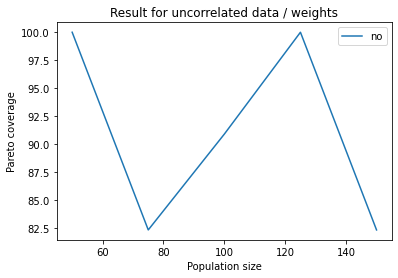

In [25]:
df_cov.plot(title="Result for uncorrelated data / weights", xlabel="Population size", ylabel="Pareto coverage")

### Choosing the best mutation probability parameter

In [29]:
max_weight = 3.0
iterate = 5
scores_v_m = np.zeros(iterate)
scores_w_m = np.zeros(iterate)
for i in range(iterate):
    csv = read_csv(f"Data//no_correlation_16")
    n_items = csv.shape[0]
    values = csv.value.values
    weights = csv.weight.values

    result = test(itemsNumber=n_items, mutationProbability=i/10, generationsNumber=70, populationSize=125, maxWeight=3, v=values, w=weights)
    pareto = getPareto(n_items, weights, values, max_weight)

    pareto_coverage[i] = getParetoCoverage(result, pareto)


In [32]:
mutation = [10*x for x in range(iterate)]
df_cov = DataFrame(data=pareto_coverage, columns=["no"], index = mutation)


<AxesSubplot:title={'center':'Result for uncorrelated data / weights'}, xlabel='Mutation probability [%]', ylabel='Pareto coverage'>

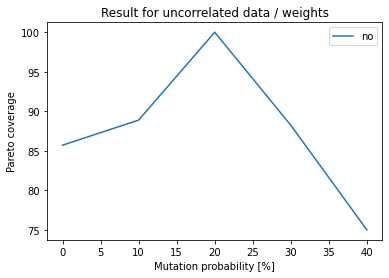

In [33]:
df_cov.plot(title="Result for uncorrelated data / weights", xlabel="Mutation probability [%]", ylabel="Pareto coverage")

In [34]:
correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                        
    
scores_v = np.zeros((len(item_counts), len(correlation_levels)))
scores_w = np.zeros((len(item_counts), len(correlation_levels)))
pareto_coverage = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"Data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values
        
        pareto = getPareto(n_items, weights, values, 3)

        result = test(itemsNumber=n_items, mutationProbability=0.2, generationsNumber=50, populationSize=125, maxWeight=3, v=values, w=weights)     
        bestScores = result[1]
        bestWeights = result[2]

        scores_v[j,i] = bestScores[-1]
        scores_w[j,i] = bestWeights[-1]
        pareto_coverage[j,i] = getParetoCoverage(result, pareto)
        print(f"Tests finished: {i*len(item_counts)+j+1}/{len(item_counts)*len(correlation_levels)}", end="\r")
        

In [35]:
df = DataFrame(data=pareto_coverage, columns=correlation_levels, index=item_counts)
df

,no,low,high
16,90.0,85.714286,94.444444
17,87.5,100.000000,100.000000
18,100.0,100.000000,95.000000
19,100.0,100.000000,100.000000
20,100.0,100.000000,100.000000
21,100.0,100.000000,100.000000
22,100.0,100.000000,100.000000
23,100.0,100.000000,100.000000
24,100.0,100.000000,100.000000


<AxesSubplot:title={'center':'Pareto coverage of NSGA-II results'}, xlabel='Items', ylabel='Pareto coverage percentage'>

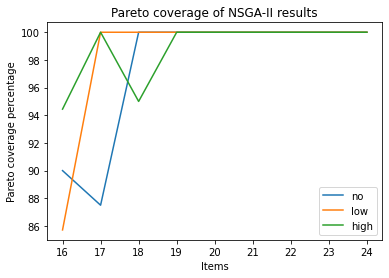

In [36]:
df.plot(title="Pareto coverage of NSGA-II results", xlabel="Items", ylabel="Pareto coverage percentage")